In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
# set random seed
SEED = 321
np.random.seed(SEED)

In [2]:
## Customization Options
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(12,4)
#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
sns.set_context("talk", font_scale=0.9)


In [3]:
# Custom Functions
def format_xdates(ax, fig=None, xtick_fontweight='bold',
               title= None):
    """Formats x-axis with minor ticks every 3 months, and major 
    ticks every year. Includes different grid options for visibility"""
    # create the locator to place ticks every 3 months.
    loc_3months = mdates.MonthLocator(interval=3)
    fmt_months = mdates.DateFormatter("%b")
    ## for major year ticks
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")
    
    ## Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), 
                       fontweight=xtick_fontweight) 
    
    ## customize minor ticks
    ax.xaxis.set_minor_locator(loc_3months)
    ax.xaxis.set_minor_formatter(fmt_months)
    ## customize major ticks
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    ## Making major/minor gridlines visually distince
    ax.grid(which='minor',axis='x',ls=":")
    ax.grid(which='major',axis='x',color='k')
    if fig is None:
        fig = ax.get_figure()
    ## rotate the dates
    fig.autofmt_xdate(which='major',rotation=90,ha='center')
    return fig,ax



# Part 1 
1. Load in the Zillow Home Value Index dataframe
2. Filter the 4 largest cities into a new dataframe
3. Melt the data into a long-form and prepare it for a time series analysis 
4. Resample the dataframe as monthly frequency, grouped by City 

In [91]:
# loading and exploring the data
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv'
df = pd.read_csv(url)
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0


In [92]:
df.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName', '2000-01-31', '2000-02-29',
       ...
       '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
       '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30'],
      dtype='object', length=281)

In [93]:
# filter the dataframe to include the 4 largest cities 
largest_cities = df[df['SizeRank'].isin([0, 1, 2, 3])]
largest_cities

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0


In [95]:
# melting the data to convert it to to long-form
melted_df = pd.melt(largest_cities, id_vars=['RegionID', 'RegionName', 'SizeRank', 'RegionType', 'StateName'],
                  var_name='Date', value_name='HomeValue')
melted_df

,RegionID,RegionName,SizeRank,RegionType,StateName,Date,HomeValue
0,6181,New York,0,city,NY,State,NY
1,12447,Los Angeles,1,city,CA,State,CA
2,39051,Houston,2,city,TX,State,TX
3,17426,Chicago,3,city,IL,State,IL
4,6181,New York,0,city,NY,Metro,"New York-Newark-Jersey City, NY-NJ-PA"
...,...,...,...,...,...,...,...
1099,17426,Chicago,3,city,IL,2022-08-31,315587.0
1100,6181,New York,0,city,NY,2022-09-30,781622.0
1101,12447,Los Angeles,1,city,CA,2022-09-30,966595.0
1102,39051,Houston,2,city,TX,2022-09-30,272639.0


In [96]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   RegionID    1104 non-null   int64 
 1   RegionName  1104 non-null   object
 2   SizeRank    1104 non-null   int64 
 3   RegionType  1104 non-null   object
 4   StateName   1104 non-null   object
 5   Date        1104 non-null   object
 6   HomeValue   1099 non-null   object
dtypes: int64(2), object(5)
memory usage: 60.5+ KB


In [97]:
melted_df['Date'] = pd.to_datetime(melted_df['Date'], errors='coerce', format='%Y-%m-%d')
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionID    1104 non-null   int64         
 1   RegionName  1104 non-null   object        
 2   SizeRank    1104 non-null   int64         
 3   RegionType  1104 non-null   object        
 4   StateName   1104 non-null   object        
 5   Date        1092 non-null   datetime64[ns]
 6   HomeValue   1099 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 60.5+ KB


In [98]:
# setting the "Date" column as the index 
melted_df.set_index('Date', inplace=True)


In [99]:
resampled_df = melted_df.groupby('RegionName').resample('M').mean()
resampled_df

/var/folders/mm/04nbg7g95pgdtd1s3081zgfh0000gn/T/ipykernel_24506/2750058758.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = melted_df.groupby('RegionName').resample('M').mean()
/var/folders/mm/04nbg7g95pgdtd1s3081zgfh0000gn/T/ipykernel_24506/2750058758.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = melted_df.groupby('RegionName').resample('M').mean()
/var/folders/mm/04nbg7g95pgdtd1s3081zgfh0000gn/T/ipykernel_24506/2750058758.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to F

RegionID  SizeRank
RegionName Date                          
Chicago    2000-01-31   17426.0       3.0
           2000-02-29   17426.0       3.0
           2000-03-31   17426.0       3.0
           2000-04-30   17426.0       3.0
           2000-05-31   17426.0       3.0
...                         ...       ...
New York   2022-05-31    6181.0       0.0
           2022-06-30    6181.0       0.0
           2022-07-31    6181.0       0.0
           2022-08-31    6181.0       0.0
           2022-09-30    6181.0       0.0

[1092 rows x 2 columns]

# Part 2
1. Plot the home values for all 4 cities
2. Answer the following 2 questions using pandas:
    -  Which City had the highest Typical Home Value at the end of 2008? Which had the least?
    -  How much did the home values change from November 2008 to December 2008 (in dollars)?
3. Melt the data into a long-form and prepare it for a time series analysis 
4. Resample the dataframe as monthly frequency, grouped by City 

In [71]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1104 entries, NaT to 2022-09-30
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   RegionID    1104 non-null   int64 
 1   RegionName  1104 non-null   object
 2   SizeRank    1104 non-null   int64 
 3   RegionType  1104 non-null   object
 4   StateName   1104 non-null   object
 5   HomeValue   1099 non-null   object
dtypes: int64(2), object(4)
memory usage: 60.4+ KB


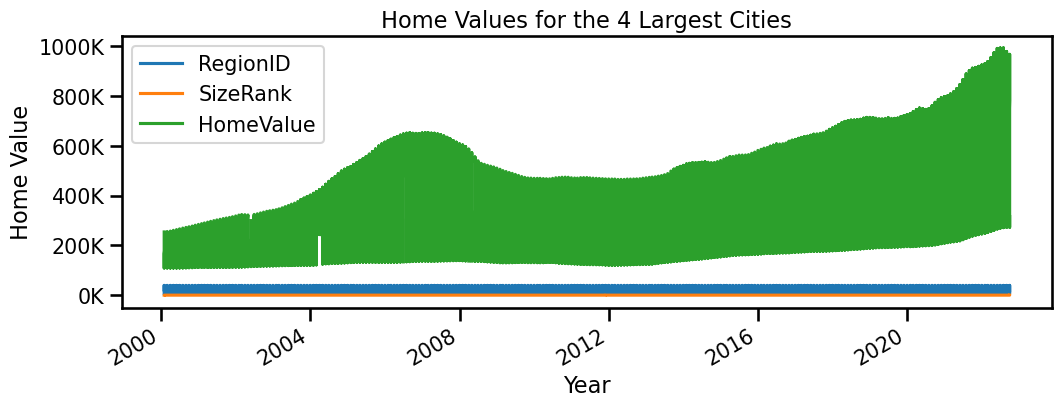

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Assuming you have already prepared the melted dataframe with time series data for the 4 largest cities

# Convert the value column to numeric
melted_df['HomeValue'] = pd.to_numeric(melted_df['HomeValue'], errors='coerce')


# Plotting the home values for all 4 cities
fig, ax = plt.subplots()

# Plotting the data
melted_df.plot(ax=ax)

# Title and axis labels
plt.title("Home Values for the 4 Largest Cities")
plt.xlabel("Year")
plt.ylabel("Home Value")

# Formatting y-axis ticks in thousands of dollars
def format_ticks(x, pos):
    'The two args are the value and tick position'
    return f'{int(x/1000)}K'

formatter = FuncFormatter(format_ticks)
ax.yaxis.set_major_formatter(formatter)

# Display the plot
plt.show()


## Which City had the highest Typical Home Value at the end of 2008? Which had the least?

In [90]:
unstacked_df = melted_df.unstack()
end_of_2008 = unstacked_df.loc[pd.IndexSlice['2008-12-31'], 'HomeValue']


city_with_highest_value = end_of_2008.idxmax()
city_with_lowest_value = end_of_2008.idxmin()


KeyError: ('2008-12-31', 'HomeValue')

In [85]:
# Answer the questions
end_of_2008 = melted_df.loc['2008-12-31']
city_with_highest_value = end_of_2008['HomeValue'].idxmax()
city_with_lowest_value = end_of_2008['HomeValue'].idxmin()

november_2008_value = melted_df.loc['2008-11-30', 'HomeValue']
december_2008_value = melted_df.loc['2008-12-31', 'HomeValue']
home_value_change = december_2008_value - november_2008_value

print(f"The city with the highest typical home value at the end of 2008 was: {city_with_highest_value[0]}")
print(f"The city with the lowest typical home value at the end of 2008 was: {city_with_lowest_value[0]}")
print(f"The home values changed by ${home_value_change:.2f} from November 2008 to December 2008.")


AttributeError: 'numpy.float64' object has no attribute 'idxmax'

## How much did the home values change from November 2008 to December 2008 (in dollars)?

In [86]:
# Assuming you have the original dataframe with the datetime index
# Let's call it "df"

# Filtering for November 2008
nov_2008 = pd.Timestamp('2008-11-01')

# Filtering for December 2008
dec_2008 = pd.Timestamp('2008-12-01')

# Calculating the home value change from November to December 2008
value_change = melted_df.loc[dec_2008] - melted_df.loc[nov_2008]

# Printing the result
print(f"The home value change from November 2008 to December 2008: {value_change}")


KeyError: Timestamp('2008-12-01 00:00:00')